# Monet Painting Generative Adversarial Network
## Project and Data Overview
In this project, I attempted to build a generative adversarial network trained on Monet's painting with the purpose to intake real photos and output a image of the photo as if it were a painting by Monet. To train we were given 300 256x256 images of Monet paintings. We were also given a folder of 7038 photos that we would then transform into Monet paintings. The purpose of this project for me was to get a better understanding of how to create GANs as it seems like one of the fastest growing subsections of deep learning as stable diffusion becomes increasingly popular as a means to create art and media.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-nnyo5z9p
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-nnyo5z9p
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=a7851bff7b353797381a56e1f3043a6967d9dbcc090407ba13b32b325f52719c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwe7rr4k/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow_examples.models.pix2pix import pix2pix
from scipy.linalg import sqrtm
from skimage.transform import resize

2024-03-05 11:41:22.955365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 11:41:22.955464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 11:41:23.089355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis
There was little to no data cleaning to be done on this set as it comes without any missing or incorrect values, simply just images. First I had to load in the jpeg images and below we can see four of the paintings as well as four of the photos. This way we get an idea of our goal as well as our input. I also split the photo dataset to possibly test any metrics of the model in the future.

In [5]:
def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis("off")
    plt.show()

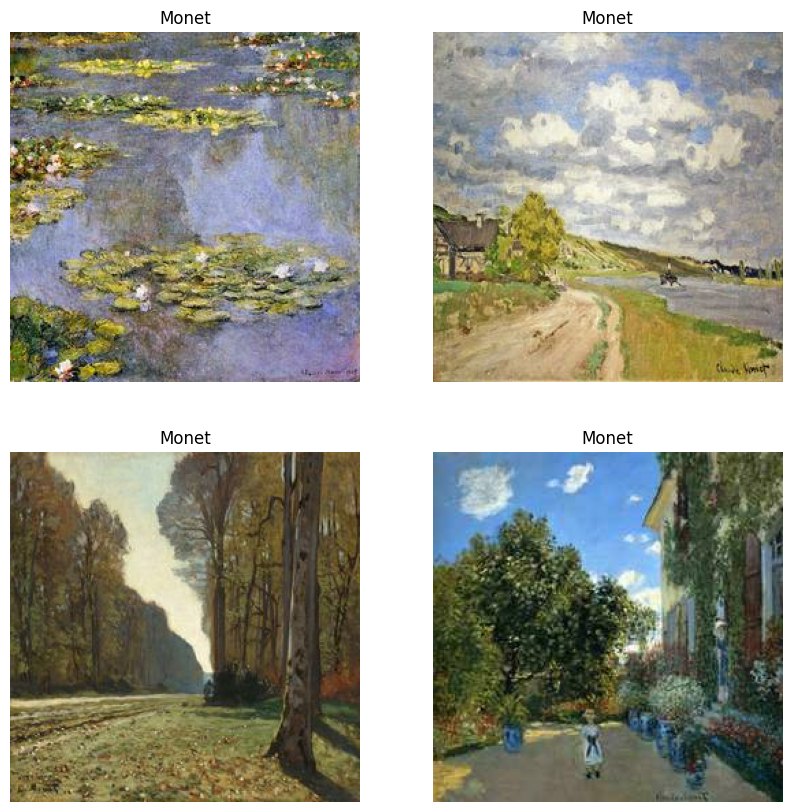

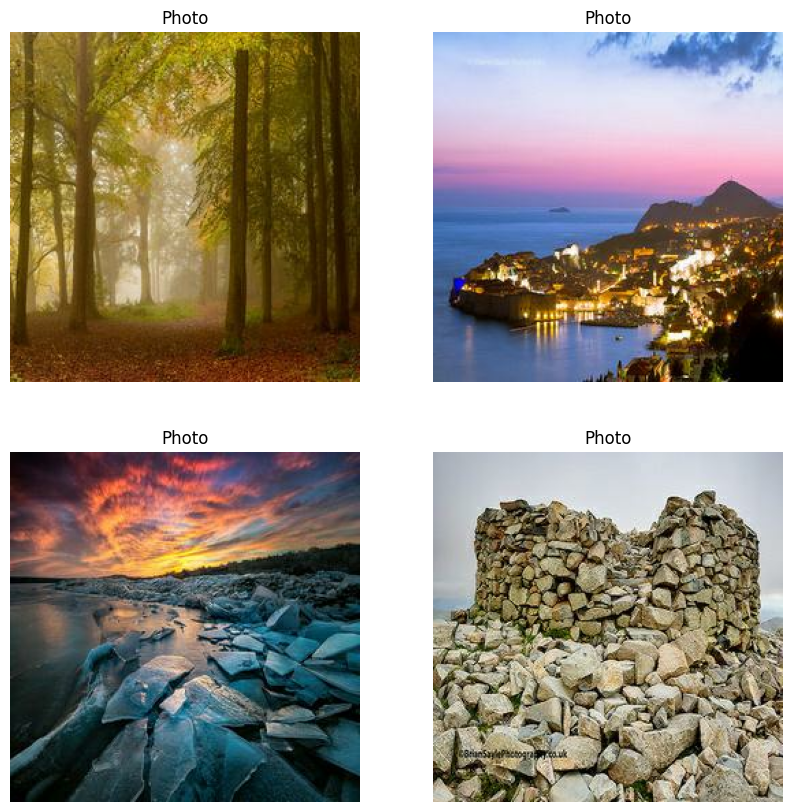

In [6]:
def load_sample_images(path, count=4):
    files = tf.io.gfile.glob(path + '/*.jpg')[:count]
    images = [tf.image.decode_jpeg(tf.io.read_file(file)) for file in files]
    return images

# Load Monet JPEG images
sample_monet_images = load_sample_images('/kaggle/input/gan-getting-started/monet_jpg')
# Display Sample Monet  images
display_images(sample_monet_images, 'Monet')

# Load Photo JPEG images
sample_photo_images = load_sample_images('/kaggle/input/gan-getting-started/photo_jpg')
# Display Sample Photo images
display_images(sample_photo_images, 'Photo')

In [7]:
def load_all_jpeg_images(path):
    files = tf.io.gfile.glob(path + '/*.jpg')  # Remove the slicing part [:count]
    images = [tf.image.decode_jpeg(tf.io.read_file(file)) for file in files]
    return images
# Load all images
monet_images = load_all_jpeg_images('/kaggle/input/gan-getting-started/monet_jpg')
photo_images = load_all_jpeg_images('/kaggle/input/gan-getting-started/photo_jpg')
print(f"Number of Monet JPEG images: {len(monet_images)}")
print(f"Number of Photo JPEG images: {len(photo_images)}")

Number of Monet JPEG images: 300
Number of Photo JPEG images: 7038


## Building and Training Model
I designed a generator with a modified U-Net architecture and a discriminator to evaluate the authenticity of generated images. During training, I used adversarial loss functions and the Adam optimizer to update the models' weights, iteratively improving the generator's ability to produce Monet-like images from photos. The process was repeated across multiple epochs to refine the models' performance.

In [8]:
photo_dataset = tf.data.Dataset.from_tensor_slices(photo_images)
monet_dataset = tf.data.Dataset.from_tensor_slices(monet_images)
# Splitting in train and test
p_train = photo_dataset.take(1000)
p_test = photo_dataset.skip(1000)

In [9]:
def build_generator():
    """Builds the generator model using a modified U-Net architecture."""
    down_stack = [
        pix2pix.downsample(64, 4, apply_instancenorm=True),  # (bs, 128, 128, 64)
        pix2pix.downsample(128, 4, apply_instancenorm=True),  # (bs, 64, 64, 128)
        pix2pix.downsample(256, 4, apply_instancenorm=True),  # (bs, 32, 32, 256)
        pix2pix.downsample(512, 4, apply_instancenorm=True),  # (bs, 16, 16, 512)
        pix2pix.downsample(512, 4, apply_instancenorm=True),  # (bs, 8, 8, 512)
        pix2pix.downsample(512, 4, apply_instancenorm=True),  # (bs, 4, 4, 512)
        pix2pix.downsample(512, 4, apply_instancenorm=True),  # (bs, 2, 2, 512)
        pix2pix.downsample(512, 4, apply_instancenorm=True),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        pix2pix.upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        pix2pix.upsample(512, 4),  # (bs, 16, 16, 1024)
        pix2pix.upsample(256, 4),  # (bs, 32, 32, 512)
        pix2pix.upsample(128, 4),  # (bs, 64, 64, 256)
        pix2pix.upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4, strides=2,
        padding='same', kernel_initializer=initializer,
        activation='tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
def build_discriminator():
    """Builds the discriminator model."""
    """Builds the discriminator model with instance normalization."""
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    x = inp

    down1 = pix2pix.downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = pix2pix.downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = pix2pix.downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1, kernel_initializer=initializer,
        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(
        1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [11]:
BUFFER_SIZE = 300
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [12]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5  # Scale by 0.5 to match the paper's implementation

def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)


generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

generator_g = pix2pix.unet_generator(3, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(3, norm_type='instancenorm')
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [13]:

@tf.function
def train_step(real_x, real_y):
    # real_x is photos, real_y is Monet-style images
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Discriminator output
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        # Discriminator loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [14]:
EPOCHS = 20 

for epoch in range(EPOCHS):
    for photo_data, monet_data in tf.data.Dataset.zip((p_train, monet_dataset)).batch(BATCH_SIZE):
        train_step(photo_data, monet_data)
    print(f'Epoch {epoch+1} done')

2024-03-05 11:42:43.408479: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_16_1/sequential_8_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done


## Results
Below we can see the input image and the predicted image that came from my model.

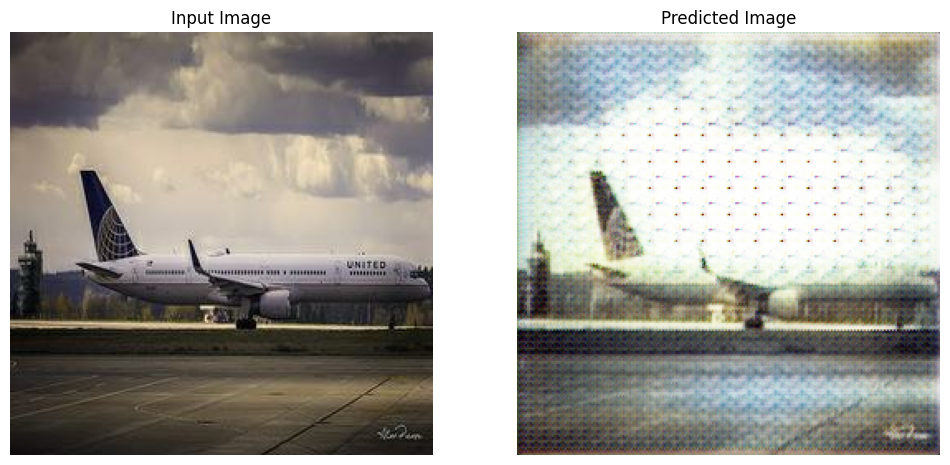

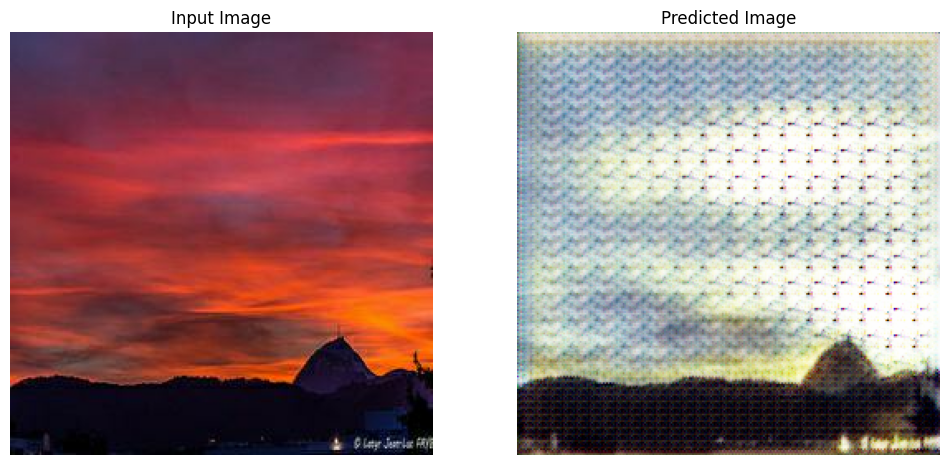

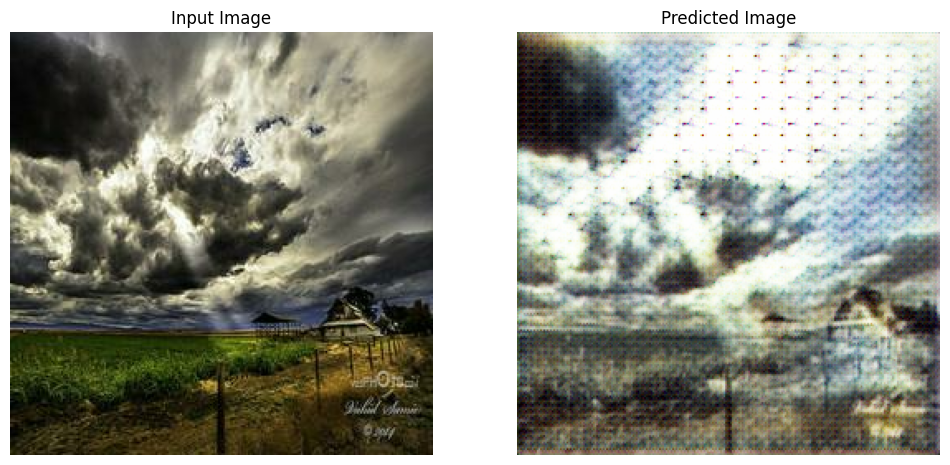

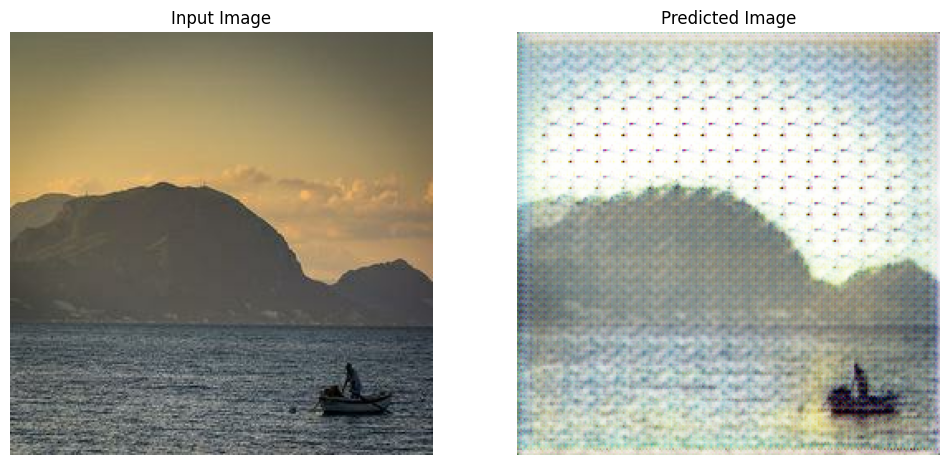

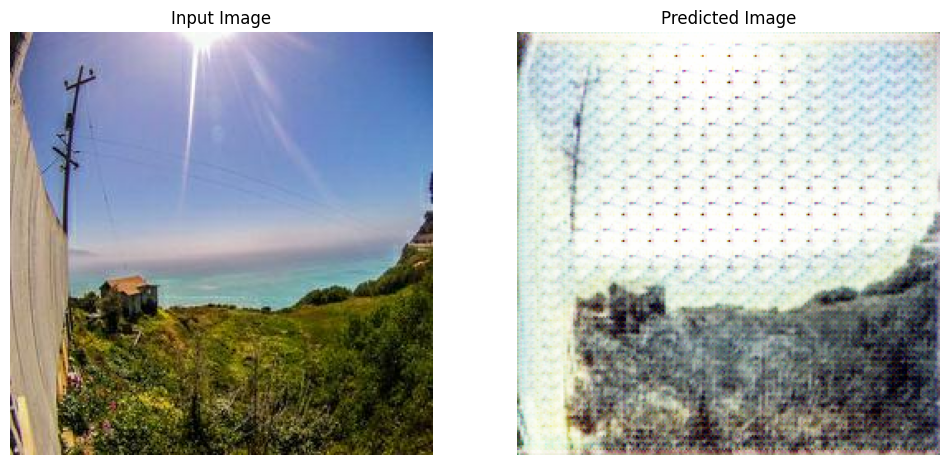

In [15]:
def generate_images(model, test_input):
    # Add a batch dimension to the input image
    test_input_batched = tf.expand_dims(test_input, axis=0)
    prediction = model(test_input_batched, training=False)

    # Remove the batch dimension
    prediction = tf.squeeze(prediction, axis=0)
    test_input_np = test_input.numpy()
    prediction_np = prediction.numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(test_input_np)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Predicted Image')
    plt.imshow(prediction_np)
    plt.axis('off')
    plt.show()


for img in p_test.take(5):
    generate_images(generator_g, img)


In [16]:
import imageio
import tensorflow as tf
import numpy as np
import zipfile
import os

def save_images(model, dataset, save_path='/kaggle/working/', num_images=7000):
    # Create a zip file to save images
    with zipfile.ZipFile(os.path.join(save_path, 'images.zip'), 'w') as img_zip:
        for i, img in enumerate(dataset.take(num_images)):
            if isinstance(img, tuple):
                img = img[0]

            # Add a batch dimension to the input image
            img = tf.expand_dims(img, axis=0)
            prediction = model(img, training=False)[0].numpy()

            # Rescale the prediction to 0-255 and convert to uint8
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img_byte_arr = tf.io.encode_jpeg(prediction).numpy()
            img_zip.writestr(f'image_{i+1}.jpg', img_byte_arr)

save_images(generator_g, photo_dataset)

## Results and Conclusion
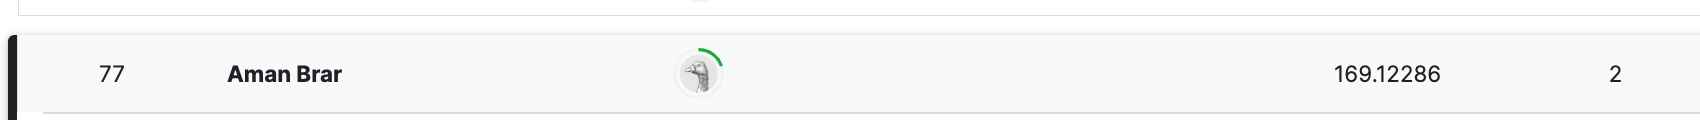
Using this model I was able to obtain a score of 169.12286 which put me at rank 77 on the Kaggle leaderboard. While it is not the best I am please with my position as it is an improvment on my intial model and score. Through iterating I was able to improve my score greatly, so I believe that given more focus, time, and resources I could perhaps further tune the model to improve the image output. Also just from looking at the images I can see somewhat of an influence of Monet's painting style, especially in the color palette of the output images. Overall, this was a very insightful experience into the complex nature of generative adversarial networks.